# Word2vec Basics

In [10]:
import numpy as np
import re

In [11]:
with open('../Datasets/data.txt') as f:
    text = f.read()

In [25]:
# Pre-processament del text per obtenir el nostre vocabulari (tokenitzacio)
text = re.sub(r'[^\w\s]', '', text)
text = text.lower()
words = sorted(list(set(text.split())))
vocab_size = len(words)

print(f'len(words) = {len(words)}')

len(words) = 274


In [27]:
def build_word_to_pos(words):
    token_to_idx = {}
    idx_to_token = {}

    for i, token in enumerate(words):
        token_to_idx[token] = i
        idx_to_token[i] = token
    return token_to_idx, idx_to_token

In [32]:
token_to_idx, idx_to_token = build_word_to_pos(words)
print(f'len(token_to_idx) = {len(token_to_idx)}')

len(token_to_idx) = 274


In [103]:
encode = lambda s: [token_to_idx[c] for c in s.split()]
decode = lambda l: ''.join([idx_to_token[i]+ " " for i in l])

In [104]:
def one_hot_encode(token, size):
    vec = np.zeros(size)
    vec[token] = 1
    return vec

# Obtenim les dades preparades per entrenar
# Retorna la llista x, el token actual, i la llista y, el context
def get_train_data(text, window_size):
    data = encode(text)
    x = []
    y = []
    for i in range(len(data)):
        for j in range(1, window_size+1):
            if i - j >= 0:
                x.append(one_hot_encode(data[i], vocab_size))
                y.append(one_hot_encode(data[i - j], vocab_size))
            if i + j < len(data):
                x.append(one_hot_encode(data[i], vocab_size))
                y.append(one_hot_encode(data[i + j], vocab_size))
    return np.asarray(x), np.asarray(y)

X, Y = get_train_data(text, 2)
print(X.shape)
print(Y.shape)


(3386, 274)
(3386, 274)


In [105]:
# Inicalitzem el model
def initialitze_model(n_embd):
    model = {
        "w1": np.random.randn(vocab_size, n_embd),
        "w2": np.random.randn(n_embd, vocab_size)
    }
    return model

def softmax(X):
    exps = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return exps / np.sum(exps, axis=-1, keepdims=True)

def forward_pass(model, input):
    state = {}
    
    state["first_layer"] = input @ model["w1"]
    state["second_layer"] = state["first_layer"] @ model["w2"]
    state["z"] = softmax(state["second_layer"])
    return state

model = initialitze_model(20)
print(len(forward_pass(model, X)["z"][0]))

274


In [106]:
X.shape

(3386, 274)

In [107]:
model.keys()

dict_keys(['w1', 'w2'])

In [108]:
model['w2'].shape, model['w1'].shape

((20, 274), (274, 20))

Note that the forward pass computes the first layer embedding with `input @ model["w1"]`
This is very wastefull since we know by contruction that input vectors have all components but 1 with 0 values. Hence multiplying by a 0 anything will be zero, so there is not need to compute it.


In [146]:
Xbatch = X[0:10]

What we can do is work with Xsp and Ysp as sparse representations of the vectors

In [110]:
def get_train_data_sparse(text, window_size):
    data = encode(text)
    x = []
    y = []
    for i in range(len(data)):
        for j in range(1, window_size+1):
            if i - j >= 0:
                x.append(data[i])
                y.append(data[i - j])
            if i + j < len(data):
                x.append(data[i])
                y.append(data[i + j])
    return np.asarray(x), np.asarray(y)

Xsp, Ysp = get_train_data_sparse(text, 2)
print(Xsp.shape)
print(Ysp.shape)

(3386,)
(3386,)


In [114]:
decode([Xsp[0], Ysp[0]])

'lamine yamal '

In [117]:
Xbatch.shape, model['w1'].shape

((10, 274), (274, 20))

In [128]:
def sparse_Xsp_times_model_weights(Xsp, w):
    return model['w1'][Xspbatch]

In [139]:
X_l1_sp = sparse_Xsp_times_model_weights(Xbatch, model['w1'])
X_l1 = Xbatch @ model['w1']

Let us try that both implementations yield the same hidden layer weight activation

In [142]:
# No AssertionError is printed so they are the same
np.testing.assert_almost_equal(X_l1_sp, X_l1)

In [148]:
time = %timeit -o X @ model["w1"]

1.31 ms ± 108 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [149]:
time_sp = %timeit -o sparse_Xsp_times_model_weights(Xsp, model["w1"])

1.71 µs ± 57 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [154]:
speedup = time.average / time_sp.average

In [157]:
print(f'the sparse version is {round(speedup)}x faster')

the sparse version is 767x faster


### Down below: To be continued

In [43]:
# Backpropagation
def cross_entropy(pred, target):
    epsilon = 1e-12  # small constant to avoid log(0)
    pred = np.clip(pred, epsilon, 1. - epsilon)
    return - np.sum(target * np.log(pred))

def backpropagation(model, input, target, learning_rate):
    state = forward_pass(model, input)
    da2 = state["z"] - target
    dw2 = state["first_layer"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = input.T @ da1
    model["w1"] -= learning_rate * dw1
    model["w2"] -= learning_rate * dw2
    return cross_entropy(state["z"], target)

print(backpropagation(model, X, Y, 0.01))

44936.16129878538


Iteration 0: Loss = 9427.88735864216


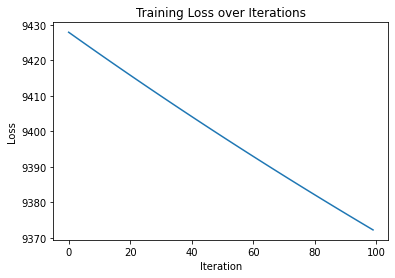

Final Loss: 9372.259002845349


In [46]:
import matplotlib.pyplot as plt

n_iter = 100
learning_rate = 0.001
losses = []

for i in range(n_iter):
    loss = backpropagation(model, X, Y, learning_rate)
    losses.append(loss)
    if i % 100 == 0:
        print(f"Iteration {i}: Loss = {loss}")

plt.plot(range(len(losses)), losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss over Iterations')
plt.show()

print(f"Final Loss: {losses[-1]}")

In [ ]:
def get_skipgram_embedding(model, word):
    vec = one_hot_encode(token_to_idx[word], len(token_to_idx))
    return vec @ model["w1"] 

lamine_embedding = get_skipgram_embedding(model, "lamine")
yamal_embedding = get_skipgram_embedding(model, "yamal")
principis_embedding = get_skipgram_embedding(model, "principis")

# Cosine similarity com a aproximació per veure la similitud entre els vectors
def cosine_similarity(a, b):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

print(lamine_embedding)
print(yamal_embedding)
print(principis_embedding)

print("Similitud entre lamine i yamal: ", cosine_similarity(lamine_embedding, yamal_embedding))
print("Similitud entre lamine i principis: ", cosine_similarity(lamine_embedding, principis_embedding))

In [ ]:
yamal = one_hot_encode(token_to_idx["yamal"], len(token_to_idx))
result = forward_pass(model, [lamine])
result = result["z"]
words = []
for word in (idx_to_token[id] for id in np.argsort(result)[::-1][0]):
    words.append(word)

print("Les 5 paraules més probables d'estar en el context de yamal son: ", words[::-1][:5])